# Preliminaries

## Load

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import sklearn as skl
import scipy as sp
import scipy.cluster.hierarchy
from sklearn import datasets

In [3]:
from skimage import color
from colorsys import rgb_to_hsv

In [5]:
import sys
sys.path.append('/home/andy/Documents/Research/pnri/Helpers')

import importlib
pcl = importlib.import_module('protoclust')
cplt = importlib.import_module('colonyplotting')

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Reload 

In [7]:
pcl = importlib.reload(pcl)
cplt = importlib.reload(cplt)

## Utilities

In [9]:
def labelXYZ(ax, xlabel, ylabel, zlabel=None, params={}):
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

# Example 1: Faces

In [8]:
faces = skl.datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64
Y = faces.target
n,d

(400, 4096)

## Inspect SVD

In [11]:
U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

<IPython.core.display.Javascript object>


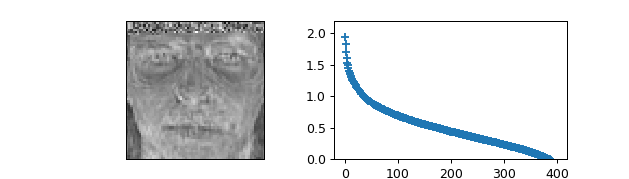

(0, 2.2)

In [34]:
fig, ax = plt.subplots(1,2, figsize=[7,2])
fig.subplots_adjust(wspace=0.1)

ax[0].imshow(Vt[:,0].reshape(64,64), cmap='gray')
cplt.clean_ax(ax[0])

ax[1].scatter(list(range(len(S))), np.log10(S), marker='+')
ax[1].set_ylim([0,2.2])

<IPython.core.display.Javascript object>


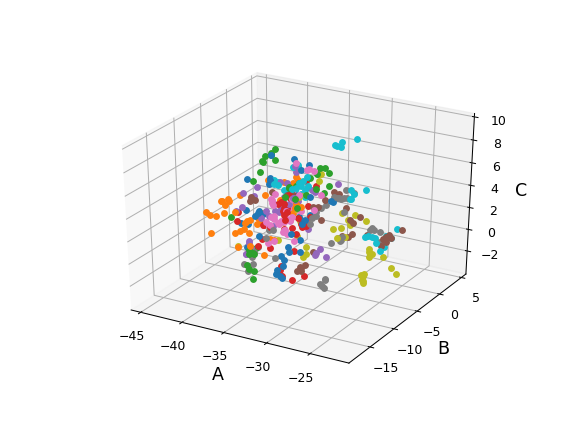

In [13]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

## An example of protoclust

In [46]:
pcl = importlib.reload(pcl)

In [47]:
dm = pcl.distance_matrix(X, lambda x,y: np.sqrt(np.sum(np.square(x-y))))
dm = dm.asarray()

In [48]:
Z, clustering_data = pcl.protoclust(dm, verbose=True, notebook=True)
# clustering, clustering_centers, clustering_distances = [np.array(i) for i in clustering_data]

In [35]:
T = sp.cluster.hierarchy.fcluster(Z, t=12, criterion='distance')
indices,_ = sp.cluster.hierarchy.leaders(Z,T)
print(len(indices))

7


<IPython.core.display.Javascript object>


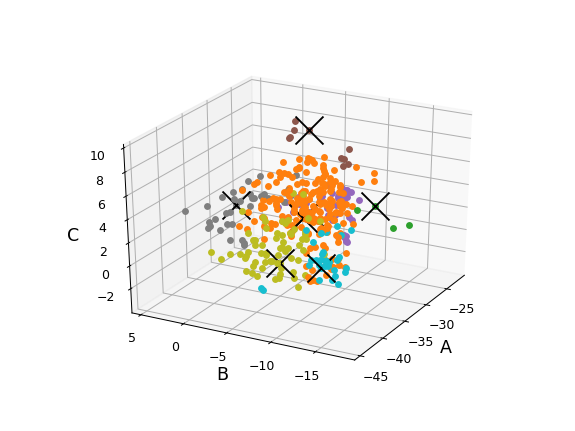

In [36]:
colors, cnorm = [mpl.cm.get_cmap('tab10'), len(indices)]

fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
for index, row in enumerate(pcX):
    c='gray'
    x1,x2,x3 = row
    ax.scatter(x1,x2,x3,color=colors(T[index]/cnorm))

for center in clustering_centers[indices]:
    x1,x2,x3 = pcX[center,:3]
    ax.scatter(x1,x2,x3, color='k', s=500, marker='x')
             
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

<IPython.core.display.Javascript object>


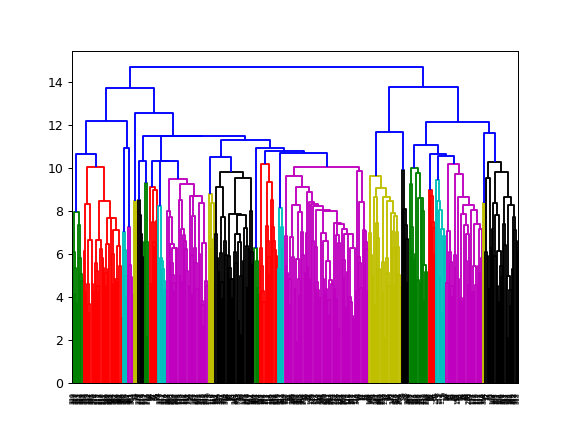

In [37]:
fig = plt.figure()
sp.cluster.hierarchy.dendrogram(Z, truncate_mode='level', distance_sort=True);

<IPython.core.display.Javascript object>


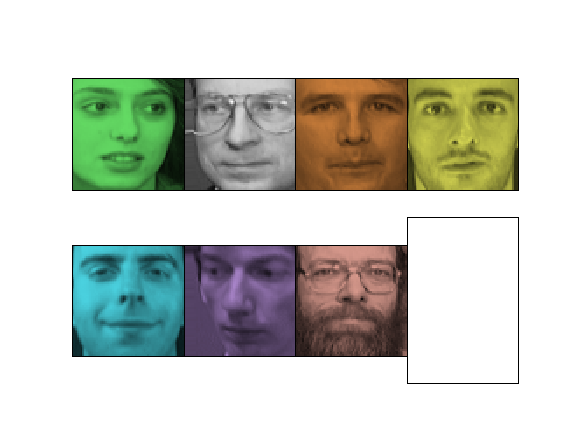

In [38]:
fig, ax = plt.subplots(2,4)
fig.subplots_adjust(wspace=0, hspace=0)
for i,row in enumerate(np.sort(clustering_centers[indices])):
    if len(ax.flatten()) == i:
        break
    im = X[row].reshape(64,64)
    im = color.gray2rgb(X[row].reshape(64,64))
    c_hsv = rgb_to_hsv(*colors(T[row]/cnorm)[:-1])
    im = cplt.colorize(im, c_hsv[0], .75*c_hsv[1])
    ax.flatten()[i].imshow(im, cmap='gray')
[cplt.clean_ax(iax) for iax in ax.flat];

# Example 2: Words

In [170]:
from scipy.io import loadmat

In [173]:
words = loadmat('Playground/grolier15276.mat')
X = words['grolier'].toarray()
n,d = X.shape

In [174]:
n,d

(15276, 30991)

In [175]:
def pairwise_dissimilarity(x,y):
    return 1 - np.sum(x*y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [ ]:
# Too slow to run in python, unfortunately.
dm = pcl.distance_matrix(X, pairwise_dissimilarity)
dm = dm.asarray()

In [151]:
Z, clustering_data = pcl.protoclust(dm)
clustering, clustering_centers, clustering_distances = [np.array(i) for i in clustering_data]